In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import xesmf as xe
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
from scipy.stats import linregress
from nzmeltwater.util import cleanocn

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

In [2]:
variables = ["tas", "tos", "pr", "wind"]

era5vardict = {"tas": "2t", "tos": "sstk", "pr": "mtpr", "uas": "10u", "vas": "10v"}
ncdfvardict = {"tas": "VAR_2T", "tos": "SSTK", "pr": "MTPR", "uas": "VAR_10U", "vas": "VAR_10V"}

In [3]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="uoo03538", cores=8, processes=8, memory="100GB", walltime="04:00:00"
)
cluster.scale(8)

from dask.distributed import Client

client = Client(cluster)
client

<Client: 'tcp://192.168.94.167:36668' processes=0 threads=0, memory=0 B>

### Load model and ERA5 data

In [4]:
edir = Path("../data/processed/era5")
croot = Path("../data/processed/HadGEM3-GC31-LL")

In [5]:
ddict = {}
for var in variables:
    print(var)
    
    if var == "wind":
        ucdir = croot.joinpath("historical", "Amon", "uas")
        vcdir = croot.joinpath("historical", "Amon", "vas")
        
        usdir = croot.joinpath("ssp245", "Amon", "uas")
        vsdir = croot.joinpath("ssp245", "Amon", "vas")
        
        nceu = list(edir.glob(f"e5.moda.*{era5vardict['uas']}.*-202212.nc"))[0]
        ncev = list(edir.glob(f"e5.moda.*{era5vardict['vas']}.*-202212.nc"))[0]
        
        ucfiles = sorted(list(ucdir.glob("*historical_r*.nc")))
        vcfiles = sorted(list(vcdir.glob("*historical_r*.nc")))
        usfiles = sorted(list(usdir.glob("*ssp245_r*201501-*.nc")))
        vsfiles = sorted(list(vsdir.glob("*ssp245_r*201501-*.nc")))
        
        dseu = xr.open_dataset(nceu)
        dsev = xr.open_dataset(ncev)

        dscu = xr.open_mfdataset(
            ucfiles, combine="nested", concat_dim="ensmem", chunks={"time": 12, "lat": -1, "lon": -1}
        )
        dscv = xr.open_mfdataset(
            vcfiles, combine="nested", concat_dim="ensmem", chunks={"time": 12, "lat": -1, "lon": -1}
        )

        dssu = xr.open_mfdataset(
            usfiles, combine="nested", concat_dim="ensmem", chunks={"time": 12, "lat": -1, "lon": -1}
        )
        dssv = xr.open_mfdataset(
            vsfiles, combine="nested", concat_dim="ensmem", chunks={"time": 12, "lat": -1, "lon": -1}
        )
        
        dsmu = xr.concat((dscu, dssu), dim="time")
        dsmv = xr.concat((dscv, dssv), dim="time")

        t_eu = dseu[ncdfvardict["uas"]].rename({"latitude": "lat", "longitude": "lon"})
        t_eu = t_eu.sel(time=slice("1979-01", "2020-12"))
        t_ev = dsev[ncdfvardict["vas"]].rename({"latitude": "lat", "longitude": "lon"})
        t_ev = t_ev.sel(time=slice("1979-01", "2020-12"))

        t_cu = dsmu["uas"].sel(time=slice("1979-01", "2020-12"))
        t_cv = dsmv["vas"].sel(time=slice("1979-01", "2020-12"))
        
        regridder = xe.Regridder(t_cv.to_dataset(), t_cu.to_dataset(), method="bilinear")
        t_cv = regridder(t_cv)
    
        t_eu = t_eu.assign_coords({"time": t_cu.time})
        t_ev = t_ev.assign_coords({"time": t_cv.time})
        
        ddict[var] = {"model": np.sqrt(t_cu**2 + t_cv**2), "obs": np.sqrt(t_eu**2 + t_ev**2)}
    
    else:
        realm = "Omon" if var == "tos" else "Amon"
        
        cdir = croot.joinpath("historical", realm, var)
        sdir = croot.joinpath("ssp245", realm, var)

        nce = list(edir.glob(f"e5.moda.*{era5vardict[var]}.*-202212.nc"))[0]
        cfiles = sorted(list(cdir.glob("*historical_r*.nc")))
        sfiles = sorted(list(sdir.glob("*ssp245_r*201501-*.nc")))

        dse = xr.open_dataset(nce)

        dsc = xr.open_mfdataset(
            cfiles, combine="nested", concat_dim="ensmem", chunks={"time": 12}
        )

        dss = xr.open_mfdataset(
            sfiles, combine="nested", concat_dim="ensmem", chunks={"time": 12}
        )

        if var == "tos":
            dsc = cleanocn(dsc)
            dss = cleanocn(dss)

        dsm = xr.concat((dsc, dss), dim="time")

        t_e = dse[ncdfvardict[var]].rename({"latitude": "lat", "longitude": "lon"})
        t_e = t_e.sel(time=slice("1979-01", "2020-12"))

        t_c = dsm[var].sel(time=slice("1979-01", "2020-12"))

        t_e = t_e.assign_coords({"time": t_c.time})

        if var == "pr":
            t_c = t_c * 24 * 3600
            t_e = t_e * 24 * 3600

        ddict[var] = {"model": t_c, "obs": t_e}

tas
tos
pr
wind


### Compute anoamlies and annual means

In [6]:
def wgtmean(da):
    return da.weighted(np.cos(np.deg2rad(da.lat))).mean(da.dims[-2:])

In [7]:
anomdict = {}
anndict = {}
datadict = {}

for var in variables:
    print(var)

    t_c = ddict[var]["model"]
    t_e = ddict[var]["obs"]
    if var == "tos":
        lat = t_c.lat.compute()
        lon = t_c.lon.compute()
        t_c_nz = t_c.where(np.logical_and(-20 > lat, lat > -60), drop=True)
        t_c_nz = t_c_nz.where(np.logical_or(lon > 135, lon < -150), drop=True)
    else:
        t_c_nz = t_c.sel(lat=slice(-60, -20), lon=slice(135, 210))

    t_c_nz_mn = wgtmean(t_c_nz).groupby("time.year").mean("time").compute()

    t_e_nz = t_e.sel(lat=slice(-20, -60), lon=slice(135, 210))
    t_e_nz_mn = wgtmean(t_e_nz).groupby("time.year").mean("time").compute()

    t_c_nz_anom = t_c_nz_mn - t_c_nz_mn.sel(year=slice(1979, 1988)).mean("year")
    t_e_nz_anom = t_e_nz_mn - t_e_nz_mn.sel(year=slice(1979, 1988)).mean("year")

    t_c_nz_ann = t_c_nz.groupby("time.year").mean(("ensmem", "time")).compute()
    t_e_nz_ann = t_e_nz.groupby("time.year").mean("time").compute()

    anomdict[var] = {"model": t_c_nz_anom, "obs": t_e_nz_anom}
    anndict[var] = {"model": t_c_nz_ann, "obs": t_e_nz_ann}
    datadict[var] = {"model": t_c_nz, "obs": t_e_nz}

tas
tos
pr
wind


### Compute linear trends and p-values

In [8]:
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])


def xregress(x, y):
    ss = xr.apply_ufunc(
        new_linregress,
        x,
        y,
        input_core_dims=[["year"], ["year"]],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float64"],
        dask_gufunc_kwargs={"output_sizes": {"parameter": 5}},
    )

    slope = ss.isel(parameter=0) * 10
    pval = ss.isel(parameter=3)

    return slope, pval

In [9]:
trenddict = {}
pdict = {}

for var in variables:
    print(var)
    trende, p_e = xregress(anndict[var]["obs"].year, anndict[var]["obs"])
    trendc, p_c = xregress(anndict[var]["model"].year, anndict[var]["model"])

    trenddict[var] = {"obs": trende, "model": trendc}
    pdict[var] = {"obs": p_e, "model": p_c}

tas
tos
pr
wind


In [10]:
def plotmap(axs, data, pval, title, cmap):
    axs.coastlines()
    axs.gridlines()
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    im = data.plot.pcolormesh(
        "lon", "lat", ax=axs, transform=ccrs.PlateCarree(), cmap=cmap
    )
    im.set_clim(-0.35, 0.35)

    levels = [0, 0.05, 0.1, 1]
    cs = pval.plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["", "....", "...."],
        colors="none",
        add_colorbar=False,
    )

    axs.set_title(title)

    return im

In [11]:
cmapdict = {"tas": "RdBu_r", "tos": "RdBu_r", "pr": "BrBG", "wind": "PiYG"}

### Compute and plot trends for all individual ensemble members

In [12]:
enstrenddict = {}
enspdict = {}

for var in variables:
    print(var)
    t_c_nz_ens = datadict[var]["model"].groupby("time.year").mean("time").compute()
    t_c_nz_trend, p_c_nz = xregress(t_c_nz_ens.year, t_c_nz_ens)

    enstrenddict[var] = t_c_nz_trend
    enspdict[var] = p_c_nz

tas
tos
pr
wind


In [13]:
def plotens(axs, data, pval, title, cmap):
    axs.coastlines()
    axs.gridlines()
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    im = data.plot.pcolormesh(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        add_colorbar=False,
    )
    im.set_clim(-0.5, 0.5)

    levels = [0, 0.05, 0.1, 1]
    cs = pval.plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["", "....", "...."],
        colors="none",
        add_colorbar=False,
    )

    axs.set_title(title)

    return im

In [14]:
labeldict = {
    "tas": "$\dot{T}$ [K decade$^{-1}$]",
    "tos": "$\dot{T}$ [K decade$^{-1}$]",
    "pr": "$\dot{P}$ [mm day$^{-1}$ decade$^{-1}$]",
    "wind": "$\dot{U}$ [m s$^{-1}$ decade$^{-1}$]"
}

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/dev/shm/jobs/52714270/ipykernel_163820/2547204049.py:2: SyntaxWarning: invalid escape sequence '\d'
  "tas": "$\dot{T}$ [K decade$^{-1}$]",
/dev/shm/jobs/52714270/ipykernel_163820/2547204049.py:3: SyntaxWarning: invalid escape sequence '\d'
  "tos": "$\dot{T}$ [K decade$^{-1}$]",
/dev/shm/jobs/52714270/ipykernel_163820/2547204049.py:4: SyntaxWarning: invalid escape sequence '\d'
  "pr": "$\dot{P}$ [mm day$^{-1}$ decade$^{-1}$]",
/dev/shm/jobs/52714270/ipykernel_163820/2547204049.py:5: SyntaxWarning: invalid escape sequence '\d'
  "wind": "$\dot{U}$ [m s$^{-1}$ decade$^{-1}$]"


tas
tos
pr
wind


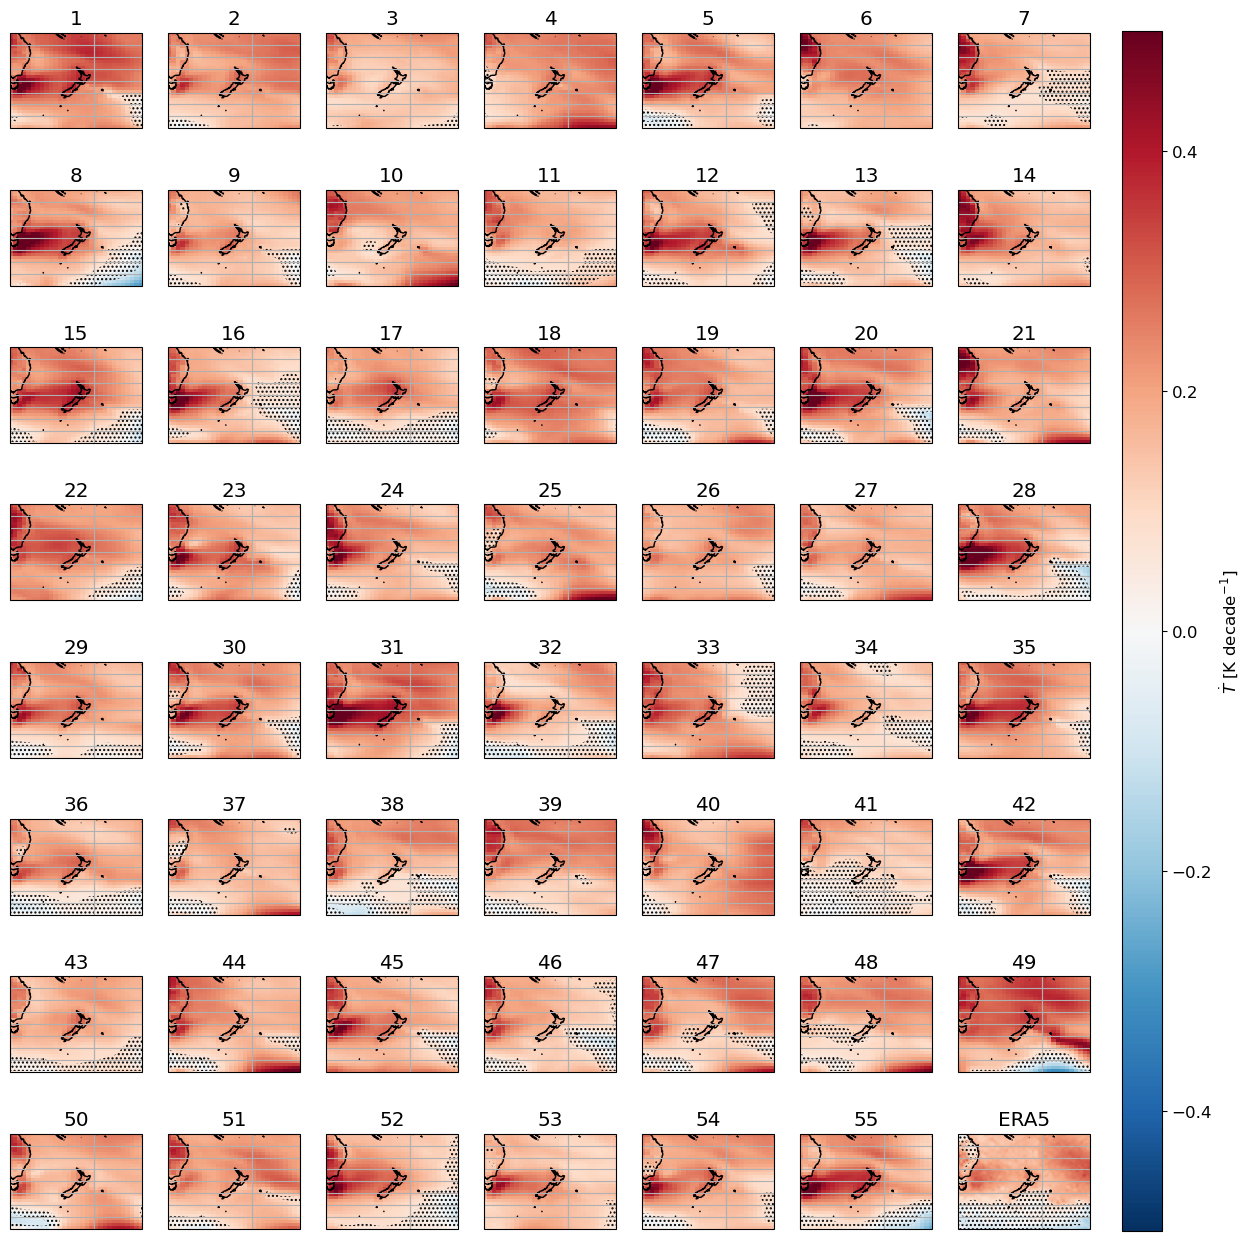

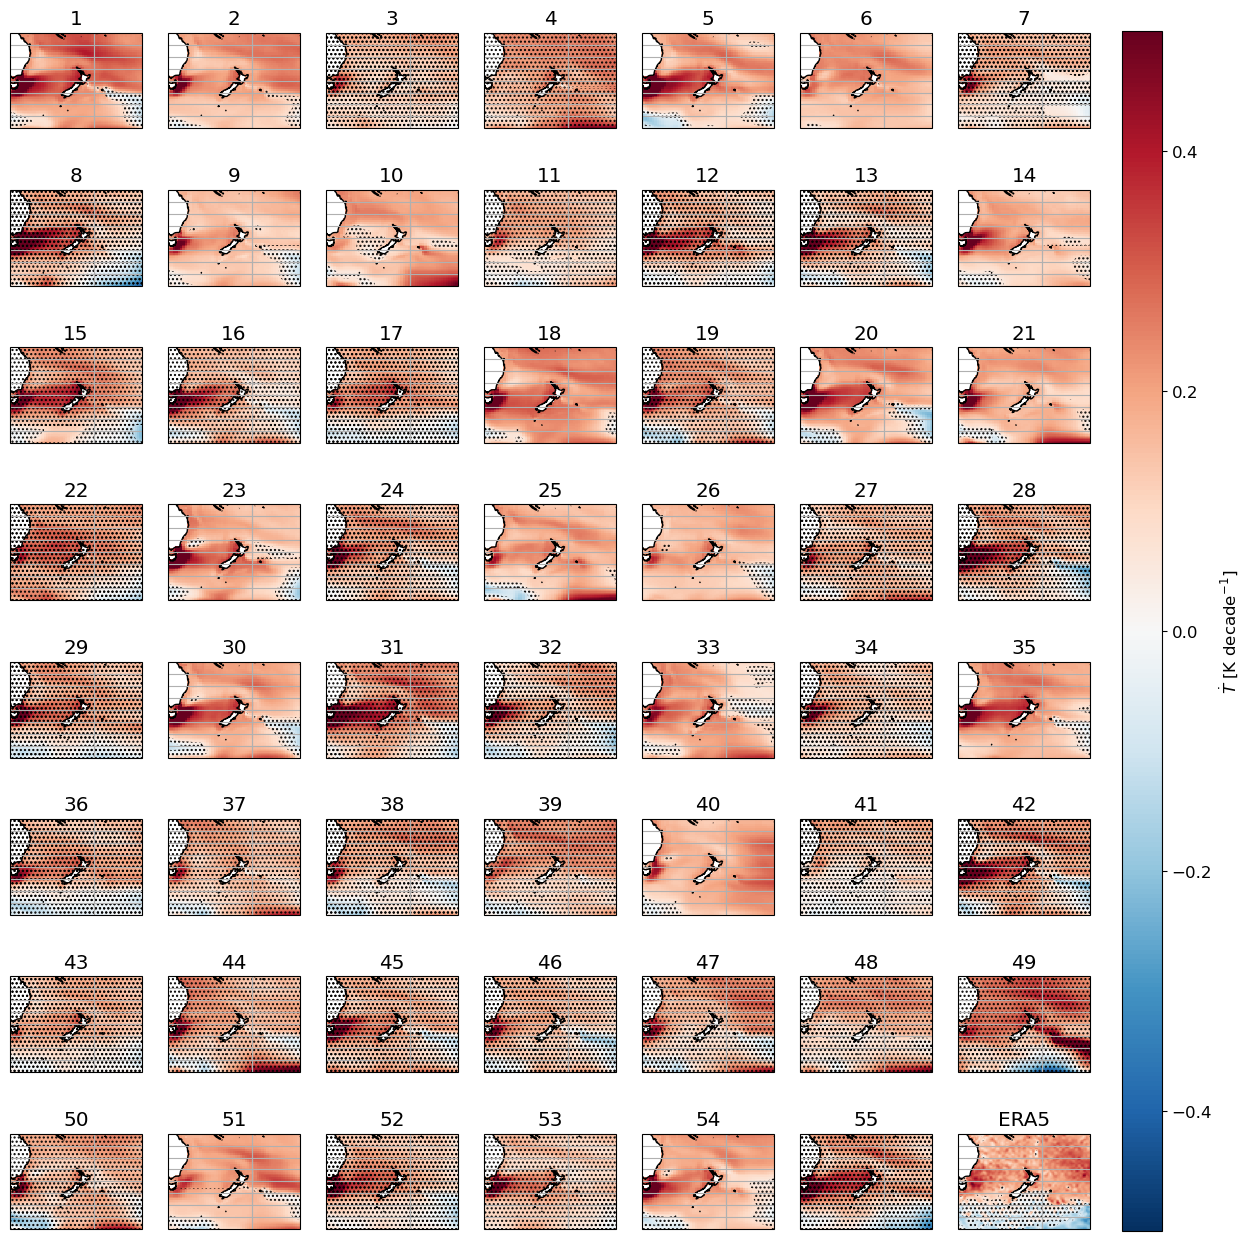

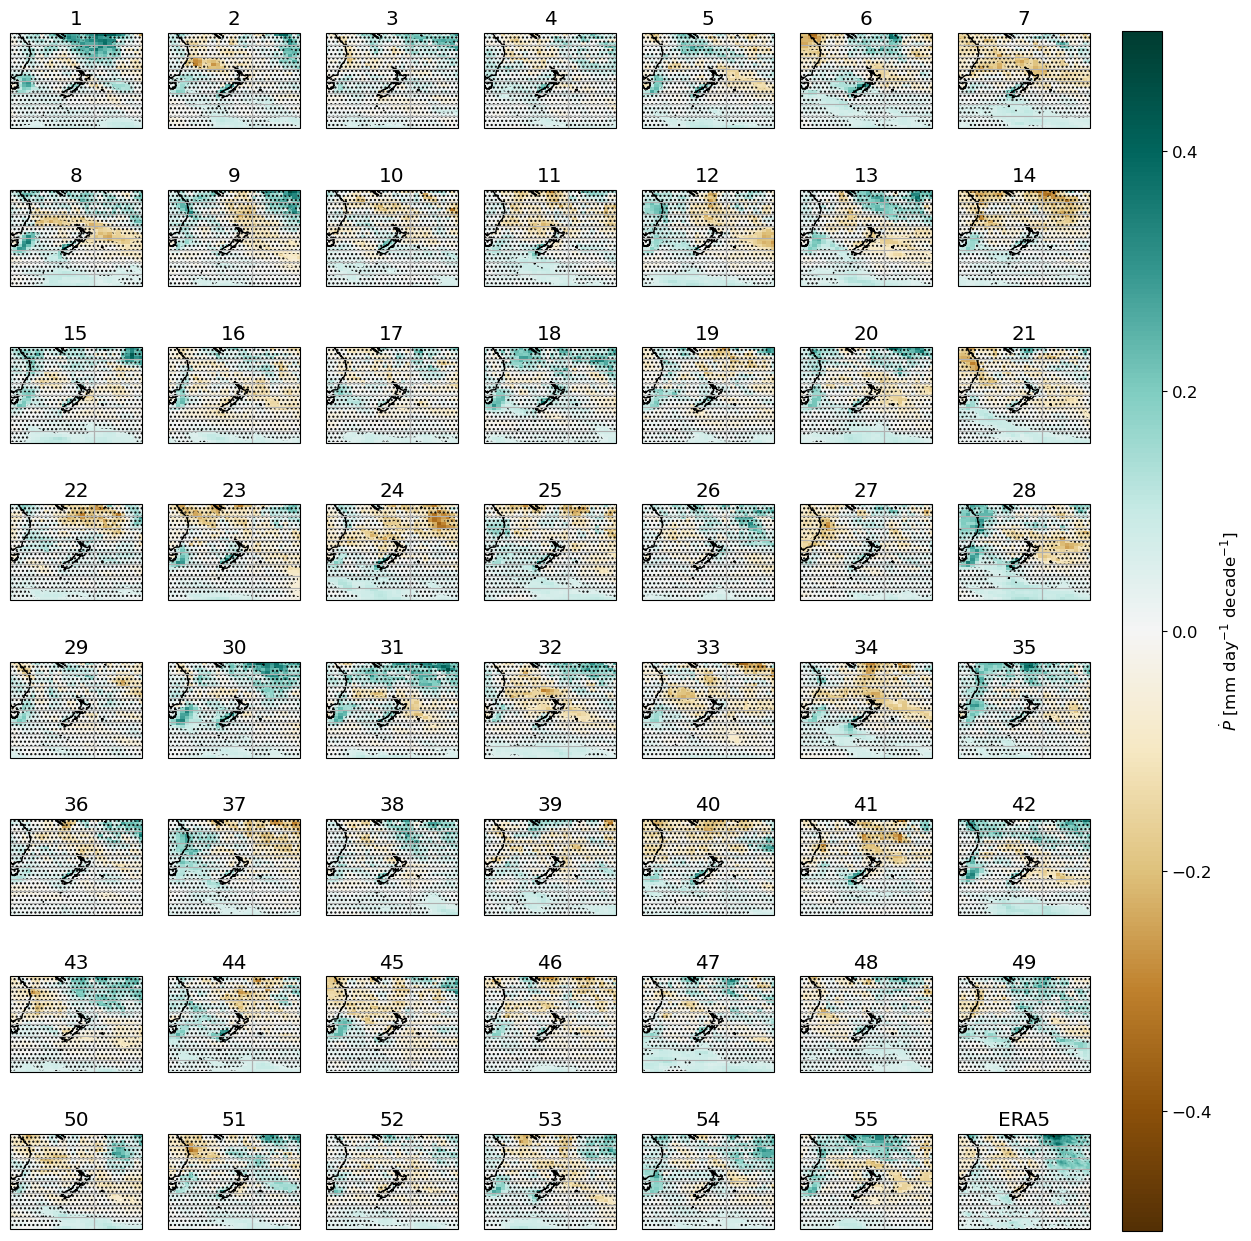

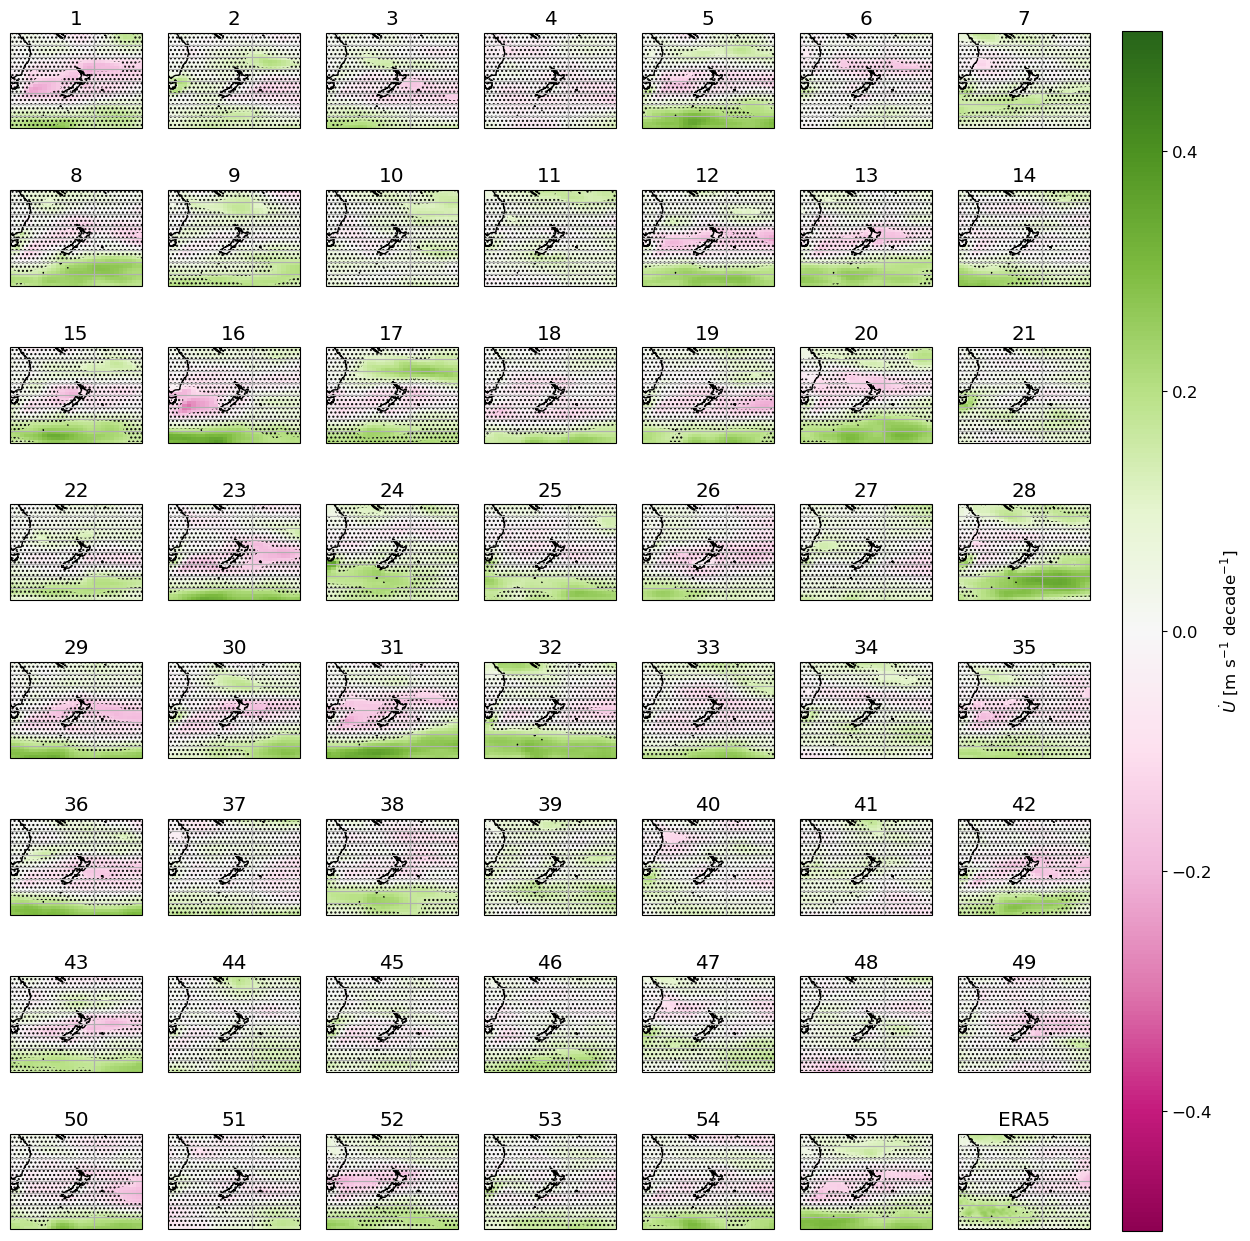

In [16]:
for var in variables:
    print(var)

    fig, axs = plt.subplots(
        8,
        7,
        figsize=(16, 16),
        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
    )
    axs = axs.flatten()

    for n in range(enstrenddict[var].ensmem.size):
        im = plotens(
            axs[n],
            enstrenddict[var].isel(ensmem=n),
            enspdict[var].isel(ensmem=n),
            n + 1,
            cmapdict[var],
        )

    im1 = plotens(
        axs[-1], trenddict[var]["obs"], pdict[var]["obs"], "ERA5", cmapdict[var]
    )

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
    cb = plt.colorbar(im1, cax=cbar_ax)
    cb.set_label(labeldict[var])

    fig.savefig(
        f"../figures/nz_{var}_HadGEM_vs_ERA5.png", bbox_inches="tight", dpi=300
    )

### Regrid ERA5 to model grid for correlation calculation

In [17]:
regriddict = {}

for var in variables:
    print(var)
    regridder = xe.Regridder(
        trenddict[var]["obs"],
        trenddict[var]["model"],
        method="bilinear",
        periodic=False,
    )

    regriddict[var] = regridder(trenddict[var]["obs"])

tas
tos
pr
wind


In [18]:
def mean2(x):
    y = np.sum(x) / np.size(x)
    return y


def corr2(a, b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a * b).sum() / np.sqrt((a * a).sum() * (b * b).sum())
    return r

### Compute correlation and p-value between ERA5 and each ensemble member. Then pick the best one

In [27]:
bestcorrdict = {}
bestpvaldict = {}

for var in variables:
    print(var)
    corrout = xr.DataArray(
        np.zeros(55),
        dims=["ensmem"],
        coords={"ensmem": ("ensmem", enstrenddict[var].ensmem.data)},
    )
    for ens in enstrenddict[var].ensmem.data:
        corrout[ens] = corr2(enstrenddict[var].sel(ensmem=ens), regriddict[var])

    maxind = int(corrout.argmax().data)

    bestcorrdict[var] = enstrenddict[var].isel(ensmem=maxind)
    bestpvaldict[var] = enspdict[var].isel(ensmem=maxind)

tas
tos
pr
wind


### Make plot for paper

In [28]:
def plotmap2(axs, data, pval, title, annotation, cmap, var):
    axs.coastlines(zorder=101)
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, zorder=102)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {"size": 8, "color": "k"}
    gl.ylabel_style = {"size": 8, "color": "k", "rotation": 90}
    if var == "tos":
        axs.add_feature(cfeature.LAND, color="tab:gray", zorder=100)
    im = data.plot.pcolormesh(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        add_colorbar=False,
    )
    im.set_clim(-0.4, 0.4)

    levels = [0, 0.05, 0.1, 1]
    cs = pval.plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["....", "", ""],
        colors="none",
        add_colorbar=False,
    )

    cs.set_edgecolor("tab:gray")
    cs.set_linewidth(0.0)

    if var == "tas":
        axs.set_title(title)
    else:
        axs.set_title("")

    axs.annotate(annotation, xy=(-0.13, 1.0), xycoords="axes fraction", fontsize=18)

    return im

In [29]:
lettdict = {
    "tas": ["(a)", "(b)", "(c)"],
    "tos": ["(d)", "(e)", "(f)"],
    "pr": ["(g)", "(h)", "(i)"],
    "wind": ["(j)", "(k)", "(l)"]
}

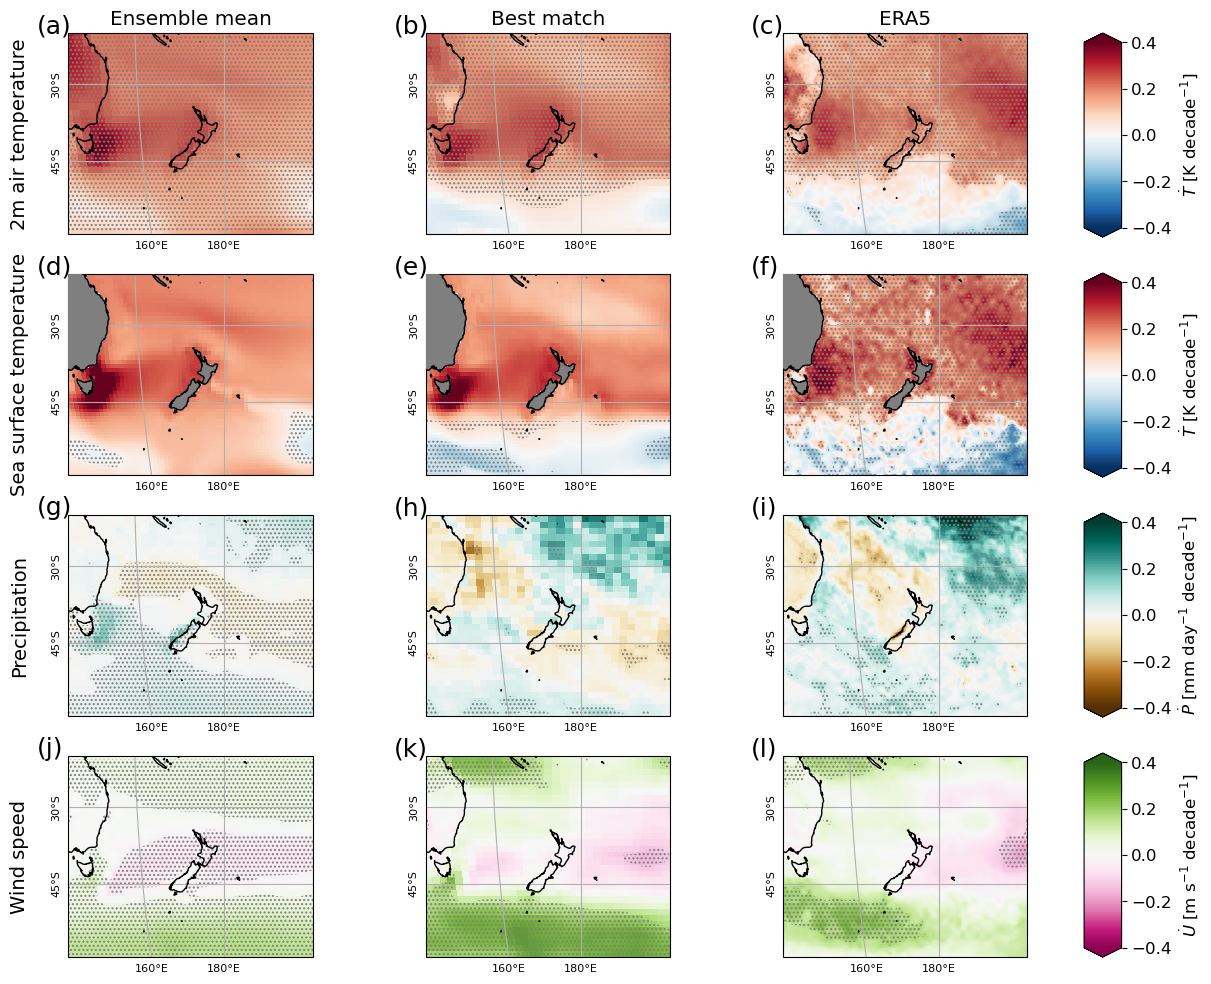

In [30]:
fig, axs = plt.subplots(
    4,
    3,
    figsize=(15, 12),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)
imdict = {}
for v, var in enumerate(variables):
    imdict[var] = plotmap2(
        axs[v, 0],
        trenddict[var]["model"],
        pdict[var]["model"],
        "Ensemble mean",
        lettdict[var][0],
        cmapdict[var],
        var,
    )
    im2 = plotmap2(
        axs[v, 1],
        bestcorrdict[var],
        bestpvaldict[var],
        "Best match",
        lettdict[var][1],
        cmapdict[var],
        var,
    )
    im3 = plotmap2(
        axs[v, 2],
        trenddict[var]["obs"],
        pdict[var]["obs"],
        "ERA5",
        lettdict[var][2],
        cmapdict[var],
        var,
    )


fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.82, 0.71, 0.025, 0.17])
cb = plt.colorbar(imdict["tas"], cax=cbar_ax, extend="both")
cb.set_label(labeldict["tas"])

cbar_ax = fig.add_axes([0.82, 0.51, 0.025, 0.17])
cb = plt.colorbar(imdict["tos"], cax=cbar_ax, extend="both")
cb.set_label(labeldict["tos"])

cbar_ax = fig.add_axes([0.82, 0.31, 0.025, 0.17])
cb = plt.colorbar(imdict["pr"], cax=cbar_ax, extend="both")
cb.set_label(labeldict["pr"])

cbar_ax = fig.add_axes([0.82, 0.11, 0.025, 0.17])
cb = plt.colorbar(imdict["wind"], cax=cbar_ax, extend="both")
cb.set_label(labeldict["wind"])

axs[0, 0].annotate(
    "2m air temperature",
    xy=(-0.2, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
    fontsize=14,
)

axs[1, 0].annotate(
    "Sea surface temperature",
    xy=(-0.2, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
    fontsize=14,
)

axs[2, 0].annotate(
    "Precipitation",
    xy=(-0.2, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
    fontsize=14,
)

axs[3, 0].annotate(
    "Wind speed",
    xy=(-0.2, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
    fontsize=14,
)

fig.savefig(
    f"../figures/allvars_era5_HadGEM_nz_comparison.png",
    bbox_inches="tight",
    dpi=300,
)